# **Estimating Soil Propeties 3D Models Using Pretrained Weights**

In [1]:
import os

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

from sklearn import preprocessing
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# from tensorflow.python.client import device_lib
# print("GPU sample processing: ")
# print(device_lib.list_local_devices())

In [4]:
DATA_DIR = '/home/daitran/Desktop/git/soil_properties/data'

ntb_data_path = os.path.join(DATA_DIR, 'NTB_black_data_remove_class_5.csv')
tb_data_path = os.path.join(DATA_DIR, '210507 TB (Blue) data_(PDF and CAD).csv')

ntb_data= pd.read_csv(ntb_data_path)
tb_data = pd.read_csv(tb_data_path)

In [5]:
remove_piles = ['TB-21', 'TB-22']

for remove_pile in remove_piles: 
    indexNames = tb_data[(tb_data['Name'] == remove_pile)].index
    tb_data.drop(indexNames , inplace=True)


In [6]:
# tb_data

### **Estimated Area**

### Load data

### Data pre-processing

In [7]:
# Specific soil types
assign_num_list = {
                    'topsoil layer': 7,
                    'reclaimed layer': 6,
                    'sedimentary layer': 5,
                    'weathered soil': 4,
                    'weathered rock': 3,
                    'soft rock': 2,
                    'moderate rock': 1,
                     'hard rock': 0,
                  }

In [8]:
ntb_names = ntb_data['Soi properties (main)']
tb_names = tb_data['Soi properties (main)']

ntb_target = ntb_names.replace(assign_num_list)
tb_target = tb_names.replace(assign_num_list)

ntb_data['Target'] = ntb_target
tb_data['Target'] = tb_target

X_train_ntb = ntb_data[['X','Y','Elevation']].to_numpy()
y_train_ntb = ntb_data['Target'].to_numpy()

X_train_tb = tb_data[['X1(CAD)','Y1(CAD)','Elevation']].to_numpy()
y_train_tb = tb_data['Target'].to_numpy()

# merge NTB and TB
X_train_merged_ntb_tb = np.concatenate((X_train_ntb, X_train_tb), axis=0)
y_train_merged_ntb_tb = np.concatenate((y_train_ntb, y_train_tb), axis=0)

# https://scikit-learn.org/stable/modules/preprocessing.html
normalizer = preprocessing.MinMaxScaler()

normalizer.fit(X_train_merged_ntb_tb)


normalized_X_train_ntb = normalizer.transform(X_train_ntb)
normalized_X_train_tb = normalizer.transform(X_train_tb)
normalized_X_merged_ntb_tb = np.concatenate((normalized_X_train_ntb, normalized_X_train_tb), axis=0)



# ## Unnormalize
# normalized_X_train_ntb = X_train_ntb
# normalized_X_train_tb = X_train_tb

# X_train_merged_ntb_tb = np.concatenate((X_train_ntb, X_train_tb), axis=0)
# normalized_X_merged_ntb_tb = X_train_merged_ntb_tb
# y_train_merged_ntb_tb = np.concatenate((y_train_ntb, y_train_tb), axis=0)

In [9]:
max_x = 550978
max_y = 213895

min_x = 549653
min_y = 213759

In [10]:
max_z = int(np.max(X_train_merged_ntb_tb[:,2]))

min_z = int(np.min(X_train_merged_ntb_tb[:,2]))


In [11]:
# Full test site
X_TEST_START = min_x
X_TEST_STOP = max_x
X_STEP = 5

Y_TEST_START = min_y
Y_TEST_STOP = max_y
Y_STEP = 5

ELEVATION_START = min_z
ELEVATION_STOP = max_z # change maximum elevation
ELEVATION_STEP = 60

# model_type = 'probabilistic'
model_type = 'deterministic'

In [12]:
max_z - min_z

66

# Load Pretrained Weights - *Check regression_models.ipynb file for model architecture*

In [13]:
def create_model(dim):
    model = Sequential([
        Dense(64, activation = 'relu', kernel_initializer='he_normal', input_dim = dim),
        Dense(32, activation = 'relu', kernel_initializer='he_normal'),
        Dense(16, activation = 'relu', kernel_initializer='he_normal'),
        Dense(8, activation = 'relu', kernel_initializer='he_normal'),
        Dense(1, kernel_initializer='he_normal', activation='linear')
    ])
    
    model.compile(loss='mean_squared_error',
              optimizer=tf.optimizers.Adam(learning_rate=0.001))
    
    model.summary()
    return model

In [14]:
# tfd = tfp.distributions
# tfpl = tfp.layers

# def prior(kernel_size, bias_size, dtype = None):
#     n = kernel_size + bias_size
#     prior_model = Sequential([
#         tfpl.DistributionLambda(
#             lambda t : tfd.MultivariateNormalDiag(loc = tf.zeros(n), scale_diag = tf.ones(n))
#         )
#     ])
#     return prior_model

# def posterior(kernel_size, bias_size, dtype = None):
#     n = kernel_size + bias_size
#     posterior_model = Sequential([
#         tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype = dtype),
#         tfpl.MultivariateNormalTriL(n)
#     ])
#     return posterior_model

# model_prob = Sequential([
#     tfpl.DenseVariational(units=20,
#                           input_shape=(3,),
#                           make_prior_fn=prior,
#                           make_posterior_fn=posterior,
#                           kl_weight=1/normalized_X_train_ntb.shape[0],
#                           activation='relu'),
#     tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
#                           make_prior_fn=prior,
#                           make_posterior_fn=posterior,
#                           kl_weight=1/normalized_X_train_ntb.shape[0]),
#     tfpl.IndependentNormal(1)
# ])

# def nll(y_true, y_pred):
#     return -y_pred.log_prob(y_true)

# model_prob.compile(loss=nll, optimizer=tf.optimizers.Adam(learning_rate=0.001))
# # model_prob.summary()

### Get best weights from deterministic or probabilistic model

In [15]:
def get_model_best_epoch(model, model_type, train_data = 'ntb'):
    current_dir = os.getcwd()
    if model_type:
        checkpoint_path = current_dir + "/checkpoints_best_only_{}_{}/checkpoint".format(model_type, train_data)
        print(checkpoint_path)
    model.load_weights(checkpoint_path)
    
    return model

In [16]:
# if model_type == 'deterministic':
#     print('===== Processing in deterministic type =====')
#     model = get_model_best_epoch(model = create_model(dim=3), model_type='deterministic', )
# else:
#     print('===== Processing in probabilistic type =====')
#     model = get_model_best_epoch(model = model_prob, model_type='probabilistic')

# Create Estimated Data Points

In [17]:
def test_area_generate():
    test_area = np.empty((0,3), int)
    
    for x in tqdm((range(X_TEST_START, X_TEST_STOP,X_STEP))):
        for y in (range(Y_TEST_START, Y_TEST_STOP,Y_STEP)):
            for elevation in (range(ELEVATION_START, ELEVATION_STOP, ELEVATION_STEP)):
                row = np.array([])
                row = np.array([x,y,elevation])
                row = np.expand_dims(row,axis=0)
    #             print(row.shape)
                test_area = np.append(test_area, row, axis = 0)
#             print('Locationx: {}, y: {}, elevation: {}'.format(x,y,elevation))
    return test_area

In [18]:
X_test = test_area_generate()

100%|██████████| 265/265 [00:00<00:00, 1018.24it/s]


In [19]:
X_test

array([[549653, 213759,     78],
       [549653, 213759,    138],
       [549653, 213764,     78],
       ...,
       [550973, 213889,    138],
       [550973, 213894,     78],
       [550973, 213894,    138]])

In [20]:
normalized_X_test = normalizer.fit_transform(X_test)

In [21]:
# np.unique(normalized_X_test)

In [22]:
def estimate_soil_properties(model, test_area):
    results = []
    for i in tqdm(range(len(test_area))):
        test_location = normalized_X_test[i]
        test_location = np.expand_dims(test_location, axis =0)
        result = model.predict(test_location)
#         print(result)
        results.append(int(result)-1)
    return np.array(results)

## **Predict test area using model train on NTB**

In [23]:
model = get_model_best_epoch(model = create_model(dim=3), model_type='deterministic', train_data = 'ntb')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________
/home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_ntb/checkpoint


In [24]:
y_estimate = estimate_soil_properties(model = model, test_area = normalized_X_test)

100%|██████████| 14840/14840 [04:10<00:00, 59.18it/s]


In [25]:
y_estimate[y_estimate < 0] = 0
y_estimate[y_estimate > 7] = 7

# 3D Estimated Points Visualization

In [26]:
max_x = np.max(X_test[:,0])
max_y = np.max(X_test[:,1])

min_x = np.min(X_test[:,0])
min_y = np.min(X_test[:,1])

In [27]:
# max_x = 550978
# max_y = 213825

# min_x = 213825
# min_y = 213828

In [28]:
def plot_data(x, y, labels, colours):
    
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(20, 10))
    
    ax = fig.add_subplot(121, projection='3d')

    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
        plt.xlim([min_x, max_x])
        plt.ylim([min_y, max_y])
        ax.set_zlim(80, 140)
        
    ax = fig.add_subplot(122, projection='3d')
    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
        ax.view_init(90, 0)   
        plt.xlim([min_x, max_x])
        plt.ylim([min_y, max_y])
        ax.set_zlim(80, 140)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

In [29]:
labels = {}
for k, v in assign_num_list.items():
    labels[v] = k

In [30]:
label_colours = ['black', 'brown', 'red', 'magenta',
                'pink', 'green',
                'blue','cyan','silver']

# DNN Results

In [31]:
X_train_merged_ntb_tb = np.concatenate((X_train_ntb, X_train_tb), axis=0)
normalized_X_merged_ntb_tb = np.concatenate((normalized_X_train_ntb, normalized_X_train_tb), axis=0)
y_train_merged_ntb_tb = np.concatenate((y_train_ntb, y_train_tb), axis=0)

In [32]:
X_test.shape

(14840, 3)

In [33]:
total_data = np.concatenate((X_test, X_train_merged_ntb_tb), axis = 0)

In [34]:
total_soil_types = np.concatenate((y_estimate, y_train_merged_ntb_tb), axis = 0)

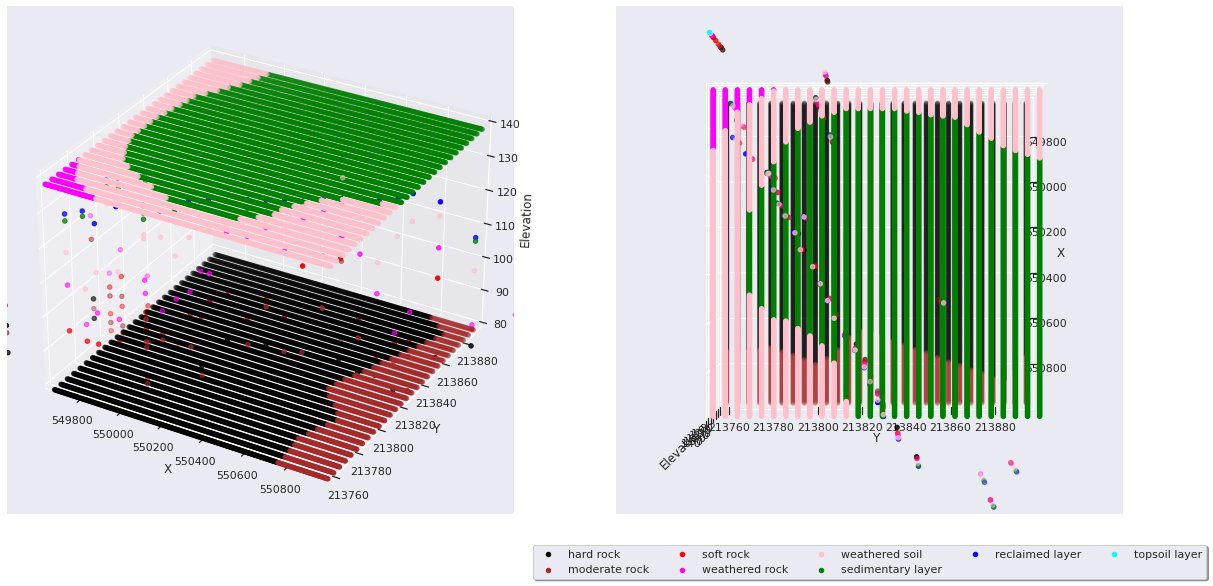

In [35]:
plot_data(total_data, total_soil_types, labels, label_colours)

plt.show()

## Generate .csv

In [32]:
data_csv = pd.DataFrame({'X': X_test[:,0],
                        'Y': X_test[:,1],
                        'Elevation': X_test[:,2],
                        'Target': y_estimate})

In [33]:
data_csv

,X,Y,Elevation,Target
0,549426,213757,78,0
1,549426,213757,83,0
2,549426,213757,88,0
3,549426,213757,93,0
4,549426,213757,98,0
...,...,...,...,...
37123,551456,213877,123,4
37124,551456,213877,128,5
37125,551456,213877,133,5
37126,551456,213877,138,5


In [34]:
data_csv.to_csv(r'/home/daitran/Desktop/git/soil_properties/output_results/export_dataframe_train_on_ntb.csv', index = False)

## **Predict test area using model train on TB**

In [35]:
# model = get_model_best_epoch(model = create_model(dim=3), model_type='deterministic', train_data = 'tb')

In [36]:
# y_estimate = estimate_soil_properties(model = model, test_area = normalized_X_test)

In [37]:
# y_estimate[y_estimate < 0] = 0
# y_estimate[y_estimate > 7] = 7

In [38]:
# plot_data(X_test, y_estimate, labels, label_colours)
# plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/estimated_tb.png')
# plt.show()

In [39]:
# data_csv = pd.DataFrame({'X': X_test[:,0],
#                         'Y': X_test[:,1],
#                         'Elevation': X_test[:,2],
#                         'Target': y_estimate})

In [40]:
# data_csv

In [41]:
# data_csv.to_csv(r'/home/daitran/Desktop/git/soil_properties/output_results/export_dataframe_train_on_tb.csv', index = False)

## **Predict test area using model train on merged NTB and TB**

In [42]:
model = get_model_best_epoch(model = create_model(dim=3), model_type='deterministic', train_data = 'merged_ntb_tb')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________
/home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_merged_ntb_tb/checkpoint


In [44]:
y_estimate = estimate_soil_properties(model = model, test_area = normalized_X_test)

 71%|███████▏  | 26499/37128 [07:28<03:00, 59.05it/s]


KeyboardInterrupt: 

In [ ]:
y_estimate[y_estimate < 0] = 0
y_estimate[y_estimate > 7] = 7

In [ ]:
plot_data(X_test, y_estimate, labels, label_colours)
plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/estimated_merged_ntb_tb.png')
plt.show()

In [ ]:
data_csv = pd.DataFrame({'X': X_test[:,0],
                        'Y': X_test[:,1],
                        'Elevation': X_test[:,2],
                        'Target': y_estimate})

In [ ]:
data_csv

In [ ]:
data_csv.to_csv(r'/home/daitran/Desktop/git/soil_properties/output_results/export_dataframe_train_on_merged_ntb_tb.csv', index = False)

# BNN Results

In [48]:
# model_type = 'probabilistic'

In [49]:
# if model_type == 'deterministic':
#     print('===== Processing in deterministic type =====')
#     model = get_model_best_epoch(model = create_model(dim=3), model_type='deterministic')
# else:
#     print('===== Processing in probabilistic type =====')
#     model = get_model_best_epoch(model = model_prob, model_type='probabilistic')

In [50]:
# y_estimate = estimate_soil_properties(model = model, test_area = normalized_X_test)

In [51]:
# y_estimate[y_estimate < 0] = 0
# y_estimate[y_estimate > 8] = 8

In [52]:
# plot_data(X_test, y_estimate, labels, label_colours)
# plt.show()